# Analysis

In [10]:
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def save_triple_scores(eli5_answer_file, open_ie_triple_file, output_file):
    kg_data = []
    with open (open_ie_triple_file) as f:
        for line in f:
            kg_data.append(json.loads(line))


    with open(eli5_answer_file) as f, open(output_file, 'w') as fw:
        for i,line in enumerate(f):
            if i == len(kg_data):
                 break
            obj = json.loads(line)
            answers = [obj["input"][:-1] + " " + x["answer"] for x in obj["output"] if x["meta"]["score"] >= 3]
            if len(answers) == 0:
                continue
            answer_words = []
            # keep question as "answer" to include those words too
            for ans in answers:
                words = set()
                for x in ans.split():
                    w = lemmatizer.lemmatize(x)
                    if w not in stop_words:
                        words.add(w.lower())
                answer_words.append(words)
            if len(answer_words) == 0:
                print(answers)
            # print(answer_words)
            kg_info = kg_data[i]
            assert kg_info["id"] == obj["id"]
            kg_triples = set(kg_info["kg"])
            kg_scores = []
            for triple in kg_triples:
                kg_words = set()
                # fix missing t:
                triple = triple.replace("\\","\t")
                for part in triple.split('\t')[:-1]: # object, relation, subject
                    kg_words.update([lemmatizer.lemmatize(w).lower() for w in part.split() if lemmatizer.lemmatize(w) not in stop_words])
                counts = []
                precisions = []
                for ans_words in answer_words:
                    cnt = len(kg_words & ans_words)
                    p = cnt / len(kg_words) if cnt > 0 else 0
                    counts.append(cnt)
                    precisions.append(p)
                tmp = {"triple":triple, "count": counts, "precision": precisions}
                kg_scores.append(tmp)
            if len(kg_scores[0]["count"]) > 0: # sort by useful triple count
                kg_scores = sorted(kg_scores, key=lambda x: (max(x["count"]), max(x["precision"])), reverse=True)
            new_obj = {"id": obj["id"], "kg_scores": kg_scores, "ans_words": str(answer_words), "question": obj['input']}
            fw.write(json.dumps(new_obj)+'\n')


[nltk_data] Downloading package wordnet to /u/srosent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /u/srosent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /u/srosent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
for i in range(0,1):
    fid = str(i)
    if i < 10:
        fid = "0" + str(i)
    save_triple_scores("/dccstor/srosent2/primeqa-mengxia/kg/train/eli5-train-kilt-oraclekg_all_ans_" + fid + ".json", 
                        "/dccstor/srosent2/primeqa-mengxia/data/openie_triples_100passages/eli5-openie-triples-" + fid + ".json",
                        "/dccstor/srosent2/primeqa-mengxia/kg/train/triple_scores/eli5-openie-triples-" + fid + "-scores.json")

useful rate DescribeResult(nobs=8728, minmax=(0.0, 0.9865771812080537), mean=0.40816237004176037, variance=0.05428132546421888, skewness=0.09351980314411043, kurtosis=-0.9193822618891301)
useful count DescribeResult(nobs=8728, minmax=(0, 214), mean=63.74896883593034, variance=1462.1889527580524, skewness=0.3548951441548525, kurtosis=-0.4032525807216021)


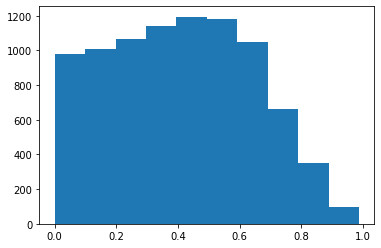

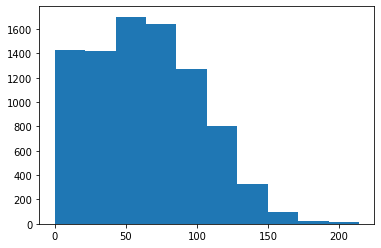

In [7]:
# sort by number of overlapping words with answers
import scipy.stats as stats
useful_rates = []
useful_counts = []

for i in range(0,1):
    fid = str(i)
    if i < 10:
        fid = "0" + str(i)
    with open ("/dccstor/srosent2/primeqa-mengxia/kg/train/triple_scores/eli5-openie-triples-" + fid + "-scores.json") as f:
        for line in f:
            obj = json.loads(line)
            kg_scores = obj["kg_scores"]
            if len(kg_scores[0]["count"]) == 0: # no good answers
                continue
            kg_scores = sorted(kg_scores, key=lambda x: (max(x["count"]), max(x["precision"])), reverse=True)
            # print(kg_scores)
            cnt_useful_triple = 0
            for item in kg_scores:
                count = max(item["count"]) if len(item["count"]) > 0 else 0 
                if count > 0:
                    cnt_useful_triple += 1
            # print(cnt_useful_triple)
            useful_counts.append(cnt_useful_triple)
            useful_rate = cnt_useful_triple / len(kg_scores)
            useful_rates.append(useful_rate)
print("useful rate", stats.describe(useful_rates))
print("useful count", stats.describe(useful_counts))
import matplotlib.pyplot as plt
plt.hist(useful_rates)
plt.show()

plt.hist(useful_counts)
plt.show()
                
            

In [12]:
with open ("/dccstor/srosent2/primeqa-mengxia/kg/train/triple_scores/eli5-openie-triples-00-scores.json") as f:
    for i,line in enumerate(f):
        if i == 10:
            break

        obj = json.loads(line)
        kg_scores = obj["kg_scores"]
        kg_scores = sorted(kg_scores, key=lambda x: (max(x["count"]), max(x["precision"])), reverse=True)
        if len(kg_scores[0]["count"]) == 0: # no good answers
            continue
        print("id", obj['id'])
        print("question", obj['question'])
        print("answer words", obj['ans_words'])
        print("Top 10:")
        for x in kg_scores[:10]:
            triple = ", ".join(x["triple"].split('\t'))
            print(max(x["count"]), max(x["precision"]), f"({triple})")
        print("Bottom 10:")
        for x in kg_scores[-10:]:
            triple = ", ".join(x["triple"].split('\t'))
            print(max(x["count"]), max(x["precision"]), f"({triple})")

id 1oy5tc
question in football whats the point of wasting the first two plays with a rush - up the middle - not regular rush plays i get those
answer words [{'-', 'one', 'whats', 'point', 'fail.', 'dimensional', 'big', 'defense', 'feel', 'honest,', 'two', 'yardage.', 'middle', 'wide', 'and', 'rush,', 'regular', 'offense', "that's", 'passing', 'get', 'keep', 'an', 'wasting', 'first', 'sometimes', 'football', 'play', 'tho', 'pas', 'rush', 'busted', 'open', 'game.'}]
Top 10:
3 1.0 (pass play, is in, football, 3128369::[0,1]-1)
3 1.0 (play, get, defense, 2948421::[0,1)-3)
3 0.75 (eligible play, is pass play in, football, 3128369::[0,1]-1)
3 0.75 (defense, reads, pass play, 7157797::[96,96)-0)
3 0.6 (play action pass, is, american football play, 690561::[1,1)-0)
3 0.42857142857142855 (drop back pass, is, passing style employed in football, 31396748::[0,1]-1)
3 0.3333333333333333 (99 yard pass play, starts at, team 's one yard line, 5052295::[3,3)-0)
2 1.0 (pass, is, passing, 31396748::[0,1]

# build datasets for classification

In [6]:

import json
import random
random.seed(42)

id2question = {}
with open("eli5-train-kilt-dpr-kg-hop2.json") as f:
    for i,line in enumerate(f):
        if i == 100:
            break
        obj = json.loads(line)
        id2question[obj["id"]] = obj["input"]
 
test_rate = 0.1

all_data = []
with open ("id2kg_scores_0_100.json") as f:
    for i,line in enumerate(f):
        obj = json.loads(line)
        kg_scores = obj["kg_scores"]
        if len(kg_scores[0]["count"]) == 0: # no good answers
            continue       
        all_data.append(obj)
        
list_ids = list(range(len(all_data)))
random.shuffle(list_ids)
test_num = int(test_rate * len(list_ids))
test_ids = list_ids[:test_num]
dev_ids = list_ids[test_num: test_num*2]
test_data = []
dev_data = []
train_data = []
for i, obj in enumerate(all_data):
    for j, kg_info in enumerate(obj["kg_scores"]):
        label = 1 if max(kg_info["count"]) > 0 else 0
        data_item = {
            "id": f"{obj['id']}_j",
            "question": id2question[obj['id']],
            "triple": kg_info["triple"],
            "label": label
        }
        if i in test_ids:
            test_data.append(data_item)
        elif i in dev_ids:
            dev_data.append(data_item)
        else:
            train_data.append(data_item)
print(len(test_ids), len(dev_ids), len(list_ids) - len(test_ids) - len(dev_ids))
print(len(test_data), len(dev_data), len(train_data))

with open("triple_cls/data_train.json", 'w') as f:
    for x in train_data:
        f.write(json.dumps(x) + '\n')
with open("triple_cls/data_dev.json", 'w') as f:
    for x in dev_data:
        f.write(json.dumps(x) + '\n')

with open("triple_cls/data_test.json", 'w') as f:
    for x in test_data:
        f.write(json.dumps(x) + '\n')
            

9 9 72
6914 4554 44453
